In [1]:
import jax.numpy as np
from jax import jit, grad, vmap
import numpy as onp
import meshzoo
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook


In [272]:
def golden_spiral(num_pts, radius):
    if radius==0:
        return np.array([[0,0,0]])
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius

def plotly_scatter(pointsets, sizes=None, opacity=0.8):
    data = []
    #sizes = [np.ones(len(p))*s for p,s in zip(pointsets,sizes)]
    for p, s in zip(pointsets, sizes):
        a,b,c = p[:,0], p[:,1], p[:,2]
        markerparams=dict(size=s,sizemode='area',opacity=opacity)
        trace = go.Scatter3d(x=a, y=b, z=c, mode='markers', marker=markerparams)
        data.append(trace)
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(plot_figure)
    
def fresnel_mesh(vol, cutoff, n_samples=10, view=None, spacing=(1,1,1)):
    if view is not None:
        view = view
    else:
        view='front'
    #vert, norm, faces = march(vol, smooth) 
    vert, faces, norm, values= measure.marching_cubes_lewiner(vol, cutoff,spacing=(1,1,1))
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)

@jit
def E_fn(points1, points2):
    ri = np.expand_dims(points1, 0)
    rj = np.expand_dims(points2, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij

# @jit
# def lj(distances,epsilon=1):
#     lennard_jones = epsilon*( (2.4/distances)**12 - 2*(2.4/distances)**6)
#     return lennard_jones

#Do not use ! Horrible to jit
######## @jit
# def get_bond_lengths(pos, bonds):
#     bondlengths = 0
#     for bond in bonds:
#         bondlengths += np.linalg.norm(pos[bond[0]]-pos[bond[1]])
#     return bondlengths

@jit 
def get_bond_lengths(pos, bonds):
    return np.linalg.norm(pos[bonds][:,0,:]-pos[bonds][:,1,:], axis=1)

In [653]:
#create a spherical mesh made of 3-gons
points, cells = meshzoo.icosa_sphere(10)
print(onp.max(points))
#Create some random atoms:
atom_centres = onp.random.uniform(0,5,(20,3))
atom_maxmin = onp.max(atom_centres,0)-onp.min(atom_centres,0)
#increase size of mesh to cover all atoms plus a buffer:
points = points*(atom_maxmin+6)/2 #2 angstrom buffer
#translate atoms to have COM at 0,0,0
atom_centres = atom_centres-onp.mean(atom_centres,0)

1.0


In [654]:
##Collect all unique bonds:
allbonds = onp.zeros([cells.shape[0]*3,2])
for count, tri in enumerate(cells):
    allbonds[(count*3)][0] = min(tri[0], tri[1])
    allbonds[(count*3)][1] = max(tri[0], tri[1])
    allbonds[(count*3+1)][0] = min(tri[0], tri[2])
    allbonds[(count*3+1)][1] = max(tri[0], tri[2])
    allbonds[(count*3+2)][0] = min(tri[1], tri[2])
    allbonds[(count*3+2)][1] = max(tri[1], tri[2])
    
allbonds = onp.unique(allbonds,axis=0).astype(int)

In [655]:
@jit
def signed_vol_of_triangle(p1, p2, p3):
    v321 = p3[0]*p2[1]*p1[2]
    v231 = p2[0]*p3[1]*p1[2]
    v312 = p3[0]*p1[1]*p2[2]
    v132 = p1[0]*p3[1]*p2[2]
    v213 = p2[0]*p1[1]*p3[2]
    v123 = p1[0]*p2[1]*p3[2]
    return (1 / 6)*(-v321 + v231 + v312 - v132 - v213 + v123)

@jit
def make_vol(pts):
    return signed_vol_of_triangle(pts[0], pts[1], pts[2])

vmake_vol = vmap(make_vol)

In [656]:
(points.max()**3*np.pi * (4/3))

652.8072864493145

In [657]:
vmake_vol(points[cells]).sum()

DeviceArray(593.19104, dtype=float32)

In [658]:
signed_vol_of_triangle(po[0], po[1], po[2])

DeviceArray(0.11876017, dtype=float32)

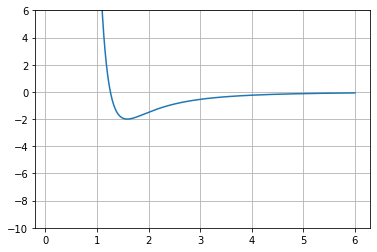

In [659]:
x = np.linspace(0.1,6,1000)
def f(x):
    return 1/(x)
    
@jit    
def lj(distances,epsilon=0.5):
    lennard_jones = epsilon*( (2/distances)**6 - 4*(2/distances)**3)
    return lennard_jones

plt.ylim(-10,6)
plt.plot(x, lj(x))
plt.grid()

In [660]:
@jit
def dist_penalty(p, a):
    distances = f(E_fn(a, p)).sum()
    return distances

@jit
def loss(p, a, b, c):
    all_distances = E_fn(a, p)
    distance_term = lj(all_distances).sum()
#    distance_term = dist_penalty(p, a)
#    volume_term = vmake_vol(p[c]).sum()
    bond_lengths = get_bond_lengths(p, b)*10
    bond_term = (bond_lengths-4)**4
    
    return distance_term+bond_term.sum()

In [661]:
loss(points, atom_centres, allbonds,cells)

DeviceArray(95521.7, dtype=float32)

In [662]:
get_bond_lengths(positions, allbonds)*10-3

DeviceArray([43.322197 , 31.762775 , 36.5581   , ...,  1.1686449,
              5.433878 ,  1.3299322], dtype=float32)

In [663]:
gl = grad(loss)

In [664]:
gl(points, atom_centres, allbonds, cells)

DeviceArray([[-5.6646423e+00,  8.2749310e+00, -2.5719669e-01],
             [ 5.5648861e+00,  7.9587116e+00, -1.6160905e-01],
             [-5.8309760e+00, -8.2828817e+00,  3.8531154e-01],
             ...,
             [-1.5606865e+02,  3.7418768e+02,  7.8139000e+01],
             [-1.5615550e+02,  3.7410175e+02, -7.8498398e+01],
             [-1.3272211e+02,  2.3226480e+02, -1.7647630e-01]],            dtype=float32)

In [665]:
positions = points.copy()

avg_sq_grad = np.zeros_like(positions)
gamma=0.9
eps=1e-8
mass = 1
lr = 0.001 #step size

for _ in tqdm_notebook(range(10000)):
    g = gl(positions, atom_centres, allbonds, cells)
    #try shifting positions by a small constant:
    #normalize gradients to 1:
#     g_norm = np.linalg.norm(g,axis=1)
#     g /= g_norm[:,None]
#     newpos = positions-g/100
    
    avg_sq_grad = avg_sq_grad * gamma + g**2 * (1. - gamma)
    newpos = positions - lr * g / np.sqrt(avg_sq_grad + eps)
    
    print(np.max(np.linalg.norm(positions-newpos, axis=1)))
    positions=newpos
    

<ipython-input-665-52d8c2213afa>:9: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0.00547741
0.005058348
0.0039288793
0.0030790956
0.0026288363
0.0025318582
0.0024760964
0.002457278
0.0027456395
0.0025648007
0.0027628627
0.0024551305
0.002385932
0.0021193016
0.0020763767
0.0022051227
0.002233291
0.0023700586
0.0025239678
0.0024594374
0.002804098
0.0027781015
0.0029217314
0.0031270704
0.002954534
0.0028929983
0.0031029512
0.0025212625
0.0028104626
0.002752289
0.0023562445
0.0021801107
0.0023453536
0.002391661
0.0024802913
0.002419922
0.0026399302
0.0025448275
0.0025902104
0.0030053097
0.0026140765
0.0029145407
0.0027591004
0.0027621572
0.0029761482
0.0026786157
0.0027693997
0.0025553638
0.0025638947
0.0024834725
0.0030975863
0.0027986432
0.0025491808
0.0026746094
0.0025469828
0.0027403412
0.0027202684
0.0027695715
0.0026554614
0.0025099146
0.002574722
0.0025412536
0.0024027124
0.0025235305
0.0026229452
0.0026718753
0.0025479274
0.0028490874
0.0024653971
0.0025932603
0.002720717
0.002763367
0.0025069518
0.0025386019
0.002438444
0.0025066042
0.0026707281
0.0025445782
0

0.0029749826
0.0029636817
0.0028935568
0.0027224654
0.0026926992
0.0028657855
0.0028766172
0.0031553002
0.0033844938
0.0032727688
0.002920481
0.0029553785
0.0026355947
0.0025836506
0.002708786
0.0027355368
0.0028035252
0.0029780655
0.0028127853
0.0030603232
0.003185323
0.0031092383
0.0034104525
0.003318656
0.0029061262
0.002601307
0.0030812803
0.0030086308
0.003087875
0.0032727143
0.0031110628
0.0031768694
0.0028385096
0.0028645336
0.0028670458
0.0028034383
0.0028437392
0.002833098
0.0027319991
0.0027310816
0.002650808
0.0030192258
0.0031122377
0.0035857793
0.003681219
0.0031283528
0.0033246179
0.0032216597
0.0027096875
0.0026396427
0.002979665
0.0032023361
0.003145468
0.0034806961
0.0030937912
0.0030088716
0.0031971415
0.0032142513
0.0028882707
0.002849056
0.0026490109
0.0035812003
0.003881333
0.0033071279
0.0031527632
0.0031819532
0.0032001396
0.0031692896
0.002764167
0.002924302
0.003218511
0.0029695162
0.0028565517
0.002944109
0.0030350322
0.0029108746
0.0029464627
0.0027286876
0.0

0.0031955338
0.003062494
0.003156718
0.003420508
0.0034836633
0.003345365
0.0029708056
0.0028913699
0.0029347516
0.0030922268
0.0031722253
0.0033898912
0.0032415919
0.003563776
0.0033526248
0.0035126081
0.0035263689
0.0033469647
0.003218179
0.0029893531
0.0032303457
0.0032645168
0.003188058
0.0032578122
0.0034787268
0.0036245727
0.003634666
0.0032304665
0.0033510376
0.0038245916
0.003373296
0.003306846
0.0032119565
0.0027390826
0.0031773841
0.003320797
0.003222063
0.0031062148
0.00312773
0.0030007167
0.0035984456
0.0030824482
0.0033474134
0.003635305
0.0031854964
0.003128921
0.0030176567
0.0034631833
0.0030897723
0.002958804
0.0033978443
0.003127907
0.0030348215
0.0030913993
0.003247142
0.0035312597
0.0032545845
0.003177257
0.003152053
0.003123728
0.0030444756
0.0029834227
0.0029005588
0.0031497516
0.0029480276
0.0029332123
0.0029007143
0.0030903674
0.0030385624
0.0030608159
0.00330048
0.0032524616
0.0029108075
0.0030629223
0.0030372094
0.0031583635
0.0029780145
0.0030344585
0.00320546

0.0035094323
0.0036680328
0.003731916
0.0030046403
0.0033016338
0.0033791263
0.003580325
0.0036459025
0.0032222022
0.002946112
0.0028722277
0.003397354
0.0031937947
0.0037128106
0.003265684
0.0035369257
0.0036718966
0.0033383148
0.0033254032
0.0030691626
0.003432211
0.003195749
0.0036985532
0.0033680059
0.0037677384
0.003189638
0.0035443376
0.0035620441
0.0034138097
0.0034663668
0.0033908754
0.0030398874
0.0031328017
0.002879096
0.0033737477
0.0028878006
0.0030529627
0.0033519347
0.0035251372
0.0034494179
0.0030703756
0.003691385
0.003361194
0.0032639054
0.0031515562
0.0029454082
0.003454106
0.003651302
0.0035434347
0.0032580344
0.003322266
0.0033186947
0.003418448
0.0036214185
0.0032857389
0.0034871942
0.0030851588
0.0032932775
0.0031281742
0.0034289835
0.0034270592
0.0032207198
0.0036387462
0.003624641
0.0032241473
0.003081263
0.0031485753
0.0034308257
0.0031791506
0.0030796833
0.0033742513
0.0033555229
0.0034298839
0.0030177375
0.0033679674
0.0038104916
0.00348762
0.0035346015
0.003

KeyboardInterrupt: 

In [651]:
plotly_scatter([np.vstack([golden_spiral(270,1.4)+i for i in atom_centres]), points, positions], [10,5,3])
#plotly_scatter([np.vstack([golden_spiral(270,1.4)+i for i in atom_centres]), positions], [10,3])

#plotly_scatter([atom_centres, points, positions], [20,5,3])
#plotly_scatter([atom_centres, positions], [20,3])

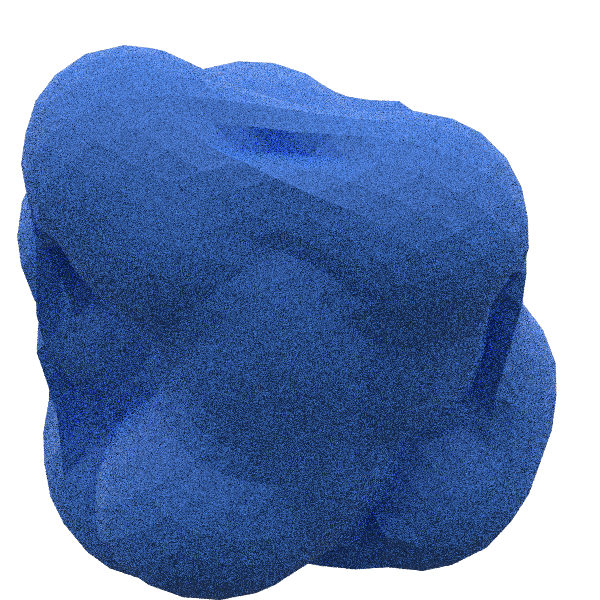

In [666]:
import fresnel
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=positions[cells].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=10, h=600, w=600)

In [667]:
import igl

In [668]:
lv, lf = igl.loop(onp.array(positions), onp.array(cells))
lv, lf = igl.loop(lv, lf)
lv, lf = igl.loop(lv, lf)

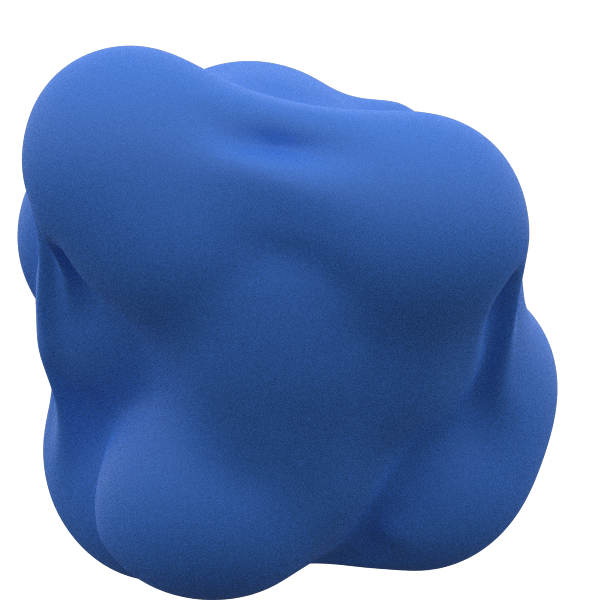

In [669]:
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=lv[lf].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=200, h=600, w=600)